In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("l33tc0d3r/indian-food-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'indian-food-classification' dataset.
Path to dataset files: /kaggle/input/indian-food-classification


In [ ]:
import os
os.listdir('/kaggle/input/indian-food-classification/Food Classification')

['momos',
 'dhokla',
 'kaathi_rolls',
 'chole_bhature',
 'masala_dosa',
 'dal_makhani',
 'burger',
 'chai',
 'chapati',
 'paani_puri',
 'pav_bhaji',
 'pakode',
 'idli',
 'jalebi',
 'kadai_paneer',
 'samosa',
 'butter_naan',
 'pizza',
 'kulfi',
 'fried_rice']

In [ ]:
import os
from PIL import Image

In [ ]:
data_dir='/kaggle/input/indian-food-classification/Food Classification'
valid_ext=['jpeg','jpg','bmp','png','webp']

In [ ]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue

    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)

        try:
            # ---- First open: read metadata ----
            with Image.open(image_path) as img:
                img_format = img.format.lower()

            if img_format not in valid_ext:
                print(f"Invalid format: {image_path}, Detected format: {img_format}")
                continue   # don't delete yet

            # ---- Second open: verify integrity ----
            with Image.open(image_path) as img:
                img.verify()

        except Exception as e:
            print(f"Corrupted image: {image_path}, Error: {e}")

Invalid format: /kaggle/input/indian-food-classification/Food Classification/momos/026.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/chole_bhature/038.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/chai/078.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/idli/026.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/kulfi/090.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/fried_rice/173.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/fried_rice/043.jpg, Detected format: mpo


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,seed=42,image_size=(224, 224))

Found 6269 files belonging to 20 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
# data = data.map(lambda x,y: (x/255, y))

In [ ]:
data_iter = data.as_numpy_iterator().next()

In [ ]:
data = data.shuffle(buffer_size=6269, seed=42)

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)


In [ ]:
train_size

137

In [ ]:
val_size

19

In [ ]:
train_ds = data.take(train_size)
val_ds   = data.skip(train_size).take(val_size)
test_ds  = data.skip(train_size + val_size)

In [ ]:
# train_iter=train_ds.as_numpy_iterator().next()

In [ ]:
# train_iter[0].shape

(32, 224, 224, 3)

In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False   # Phase 1


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(20, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 141s 532ms/step - accuracy: 0.1121 - loss: 3.1394 - val_accuracy: 0.5099 - val_loss: 2.0455
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 134s 528ms/step - accuracy: 0.4066 - loss: 2.1189 - val_accuracy: 0.6513 - val_loss: 1.4468
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 136s 527ms/step - accuracy: 0.5077 - loss: 1.6783 - val_accuracy: 0.7368 - val_loss: 1.0953
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 136s 530ms/step - accuracy: 0.5988 - loss: 1.4032 - val_accuracy: 0.7901 - val_loss: 0.8951
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 526ms/step - accuracy: 0.6463 - loss: 1.2250 - val_accuracy: 0.7829 - val_loss: 0.8535
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 527ms/step - accuracy: 0.6915 - loss: 1.0832 - val_accuracy: 0.8264 - val_loss: 0.7160
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 134s 523ms/step - accuracy: 0.6996 - loss: 1.0570 - val_accuracy: 0.8182 - val_loss: 0.6913
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 141s 523ms/step - accuracy: 0.7151 -

In [ ]:
base_model.trainable = True

# Freeze bottom layers, fine-tune top ones
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 146s 547ms/step - accuracy: 0.6621 - loss: 1.1586 - val_accuracy: 0.8257 - val_loss: 0.6075
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 140s 539ms/step - accuracy: 0.7979 - loss: 0.6799 - val_accuracy: 0.8678 - val_loss: 0.4787
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 533ms/step - accuracy: 0.8422 - loss: 0.5556 - val_accuracy: 0.8750 - val_loss: 0.3882
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 155s 680ms/step - accuracy: 0.8608 - loss: 0.4808 - val_accuracy: 0.8849 - val_loss: 0.3803
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 135s 539ms/step - accuracy: 0.8745 - loss: 0.4192 - val_accuracy: 0.8964 - val_loss: 0.3164
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 542ms/step - accuracy: 0.8910 - loss: 0.3626 - val_accuracy: 0.9211 - val_loss: 0.2554
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 137s 544ms/step - accuracy: 0.9025 - loss: 0.2955 - val_accuracy: 0.9441 - val_loss: 0.1958
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 136s 538ms/step - accuracy: 0.9228 -

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.9619 - loss: 0.1284
Test Accuracy: 0.9584964513778687


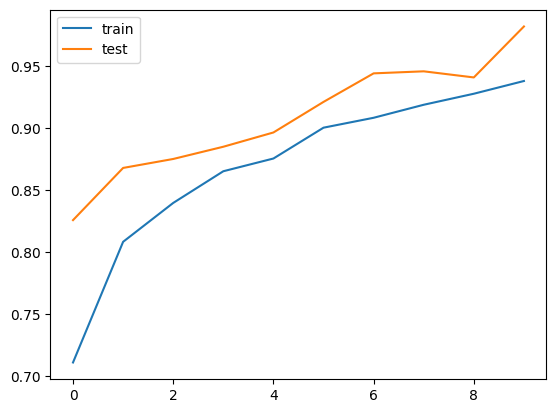

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['train','test'],loc='upper left')
plt.show()

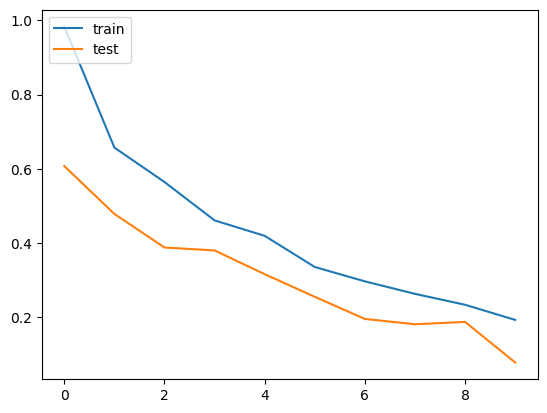

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.legend(['train','test'],loc='upper left')
plt.show()

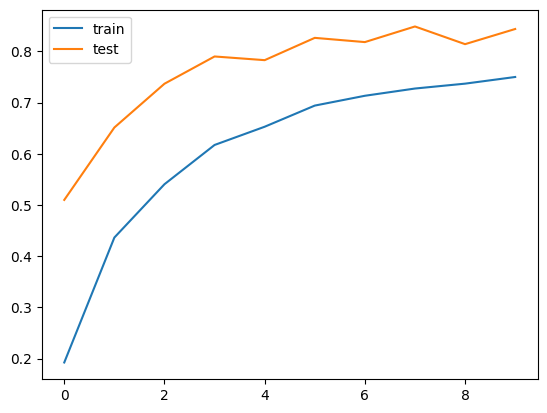

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'],loc='upper left')
plt.show()

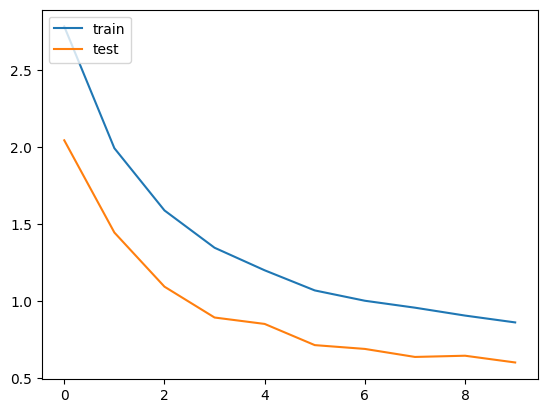

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
model.save("indian_food_classifer.h5")

In [ ]:
model.save("indian_food_classifier.keras")